# 0. Import Statments

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.image as mpimg
import tensorflow.keras as keras
from google.colab import files
import os 
from zipfile import ZipFile
import pathlib
import random

# 1. Loading the data

In [3]:
# Get the data (10% of 10 food classes from Food101)

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the folder
with ZipFile("10_food_classes_10_percent.zip") as folder:

  folder.extractall()

--2025-12-04 07:14:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.207, 108.177.11.207, 192.178.219.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   174MB/s    in 0.9s    

2025-12-04 07:14:33 (174 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [4]:
# walk through pizza_steak directory and list number of files

for dir, sub_dir, files in os.walk("10_food_classes_10_percent"):
  
  print(f"There are {len(sub_dir)} directories, and {len(files)} files in {dir}")

There are 2 directories, and 0 files in 10_food_classes_10_percent
There are 10 directories, and 0 files in 10_food_classes_10_percent/train
There are 0 directories, and 75 files in 10_food_classes_10_percent/train/sushi
There are 0 directories, and 75 files in 10_food_classes_10_percent/train/pizza
There are 0 directories, and 75 files in 10_food_classes_10_percent/train/ramen
There are 0 directories, and 75 files in 10_food_classes_10_percent/train/ice_cream
There are 0 directories, and 75 files in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories, and 75 files in 10_food_classes_10_percent/train/fried_rice
There are 0 directories, and 75 files in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories, and 75 files in 10_food_classes_10_percent/train/steak
There are 0 directories, and 75 files in 10_food_classes_10_percent/train/hamburger
There are 0 directories, and 75 files in 10_food_classes_10_percent/train/chicken_curry
There are 10 director

# 3. Inspecting the data

In [5]:
# Get the class names

data_dir = pathlib.Path("10_food_classes_10_percent/train") # turning the directory into a path object

class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class names from the sub-directories

pd.DataFrame(data={"meal_name": class_names})

,meal_name
0,chicken_curry
1,chicken_wings
2,fried_rice
3,grilled_salmon
4,hamburger
5,ice_cream
6,pizza
7,ramen
8,steak
9,sushi


In [6]:
def visualize_data(class_name): 

    dir = "10_food_classes_10_percent/train/" + class_name 

    img_names = random.sample(population=os.listdir(dir), k=3)

    fig, axes = plt.subplots(ncols=3, figsize=(10, 4))

    axes = axes.flatten()

    fig.suptitle(f"{class_name.capitalize()} images", fontsize=15)


    for i in range(len(axes)):

        ax = axes[i]

        image = mpimg.imread(dir + "/" + img_names[i])

        ax.imshow(image) 

        ax.axis(False)


    

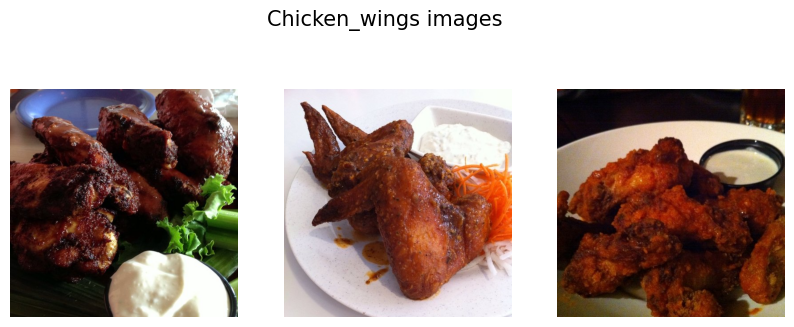

In [12]:
visualize_data(random.choice(class_names)) # I am using a random dish here, but you (TA or professor) can pass in specific dish names

# 4. Creating data loaders (preparing the data)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = [224, 224]

BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/test"

test_dir = "10_food_classes_10_percent/train" # ⚠️⚠️⚠️ I have switched the test and train dir on purpose here because 

train_datagen = ImageDataGenerator(rescale=1./255.)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="sparse", 
                                               shuffle=True)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="sparse", 
                                             shuffle=True)

Found 2500 images belonging to 10 classes.
Found 750 images belonging to 10 classes.


In [18]:
test_data.class_indices

{'chicken_curry': 0,
 'chicken_wings': 1,
 'fried_rice': 2,
 'grilled_salmon': 3,
 'hamburger': 4,
 'ice_cream': 5,
 'pizza': 6,
 'ramen': 7,
 'steak': 8,
 'sushi': 9}

# 5. Build a pure feature extractor (Keras)

In [15]:
# 1. Create base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False, # I am not including the top because I will train classical ML models 
    weights="imagenet",
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # freexing every layer

# 2. Wrap with GlobalAveragePooling2D (GAP) to get a 1D feature vector
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

x = base_model(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name="gap")(x)

feature_model = tf.keras.Model(inputs, x, name="feature_extractor")

print(feature_model.output_shape)  # every image becomes a 1D vector of length 1280


(None, 1280)


In [16]:
feature_model.summary()

Model: "feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1280)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

# 6. Turn Keras image loaders into standard NumPy feature matrices and label

⚠️ The below cell took me almost 5 minutes to run. The data could alternatively be uploaded using np.load('food101_features.npz') ⚠️

In [11]:
# Number of samples
n_train = train_data.samples # using only 10 classe, it should be 2500
n_test  = test_data.samples #  using only 10 classe, it should be 750
feat_dim = feature_model.output_shape[-1]  # 1280

# Allocate arrays
X_train = np.zeros((n_train, feat_dim), dtype="float32")
y_train = np.zeros((n_train,), dtype="int32")

X_test  = np.zeros((n_test, feat_dim), dtype="float32")
y_test  = np.zeros((n_test,), dtype="int32")

# Fill train features
i = 0
for batch_x, batch_y in train_data:
    batch_size = batch_x.shape[0]
    feats = feature_model.predict(batch_x, verbose=0)
    X_train[i:i+batch_size] = feats
    y_train[i:i+batch_size] = batch_y
    i += batch_size
    if i >= n_train:
        break

# Fill test features
i = 0
for batch_x, batch_y in test_data:
    batch_size = batch_x.shape[0]
    feats = feature_model.predict(batch_x, verbose=0)
    X_test[i:i+batch_size] = feats
    y_test[i:i+batch_size] = batch_y
    i += batch_size
    if i >= n_test:
        break


In [ ]:
# # Saving arrays to one .npz file
# np.savez('food101_features.npz', 
#          X_train=X_train, y_train=y_train, 
#          X_test=X_test, y_test=y_test)

In [ ]:
test_data.class_indices

{'chicken_curry': 0,
 'chicken_wings': 1,
 'fried_rice': 2,
 'grilled_salmon': 3,
 'hamburger': 4,
 'ice_cream': 5,
 'pizza': 6,
 'ramen': 7,
 'steak': 8,
 'sushi': 9}

# 7. Train classical models on these features (scikit‑learn)

In [14]:
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

### 7.1 logistic regression

In [15]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=5000,
        penalty="l2", 
        solver="lbfgs")
)

param_grid = {
    "logisticregression__C": [0.1, 1]
    }

grid_logreg = GridSearchCV(
    pipe,
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_logreg.fit(X_train, y_train)
best_logreg = grid_logreg.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [16]:
grid_logreg.best_params_

{'logisticregression__C': 1}

In [17]:
logreg_predictions = best_logreg.predict(X_test)

In [18]:
print(classification_report(y_true=y_test, y_pred=logreg_predictions))

              precision    recall  f1-score   support

           0       0.37      0.32      0.34        75
           1       0.38      0.35      0.36        75
           2       0.38      0.40      0.39        75
           3       0.36      0.36      0.36        75
           4       0.38      0.33      0.36        75
           5       0.42      0.52      0.46        75
           6       0.46      0.43      0.44        75
           7       0.39      0.44      0.42        75
           8       0.41      0.39      0.40        75
           9       0.21      0.23      0.22        75

    accuracy                           0.38       750
   macro avg       0.38      0.38      0.38       750
weighted avg       0.38      0.38      0.38       750



In [20]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [23]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

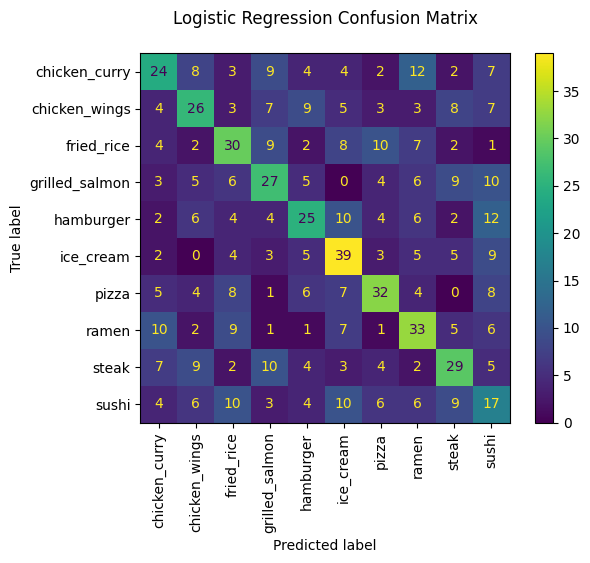

In [37]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_pred=logreg_predictions, y_true=y_test, ax=ax, display_labels=class_names)
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)
ax.set_title("Logistic Regression Confusion Matrix\n");

### 7.2 Support Vector Machine

In [38]:
from sklearn.svm import SVC 

svm_pipe = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma="scale")  
)

param_grid_svm = {
    "svc__C": [1, 10],
}

svm_grid = GridSearchCV(
    svm_pipe,
    param_grid_svm,
    cv=3,
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=-1, param_grid={'svc__C': [1, 10]}, verbose=1)

In [40]:
best_svm = svm_grid.best_estimator_

svm_predictions = best_svm.predict(X_test)

print(classification_report(y_test, svm_predictions))

              precision    recall  f1-score   support

           0       0.33      0.29      0.31        75
           1       0.21      0.23      0.22        75
           2       0.28      0.27      0.27        75
           3       0.21      0.21      0.21        75
           4       0.21      0.20      0.20        75
           5       0.31      0.37      0.34        75
           6       0.33      0.32      0.32        75
           7       0.35      0.33      0.34        75
           8       0.30      0.28      0.29        75
           9       0.26      0.27      0.26        75

    accuracy                           0.28       750
   macro avg       0.28      0.28      0.28       750
weighted avg       0.28      0.28      0.28       750



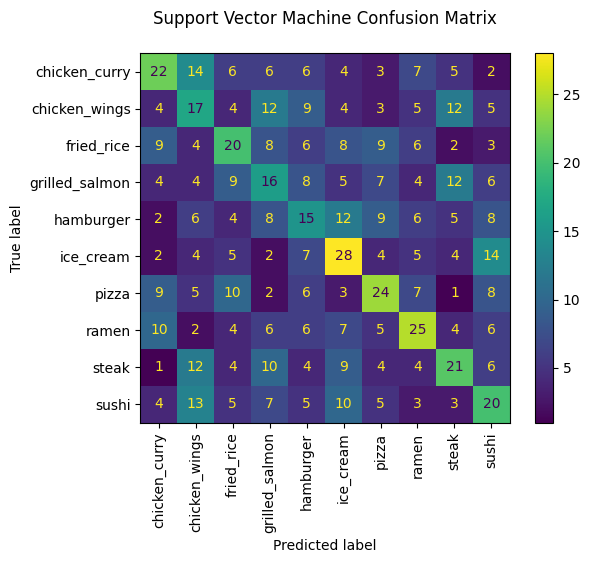

In [42]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_pred=svm_predictions, y_true=y_test, ax=ax, display_labels=class_names)
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)
ax.set_title("Support Vector Machine Confusion Matrix\n");

### 7.3 K Nearest Neighbors

k=1, val error=0.859
k=3, val error=0.851
k=5, val error=0.844
k=7, val error=0.833
k=9, val error=0.824
k=11, val error=0.825
k=15, val error=0.839
k=21, val error=0.820


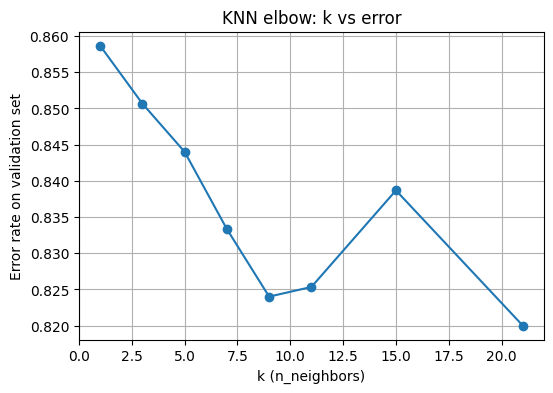

In [43]:
from sklearn.neighbors import KNeighborsClassifier

k_values = [1, 3, 5, 7, 9, 11, 15, 21]
error_rates = []

for k in k_values:
    knn = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=k, weights="distance")
    )
    knn.fit(X_train, y_train)
    y_val_pred = knn.predict(X_test)
    err = 1.0 - accuracy_score(y_test, y_val_pred)
    error_rates.append(err)
    print(f"k={k}, val error={err:.3f}")

# Plot k vs error
plt.figure(figsize=(6, 4))
plt.plot(k_values, error_rates, marker="o")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Error rate on validation set")
plt.title("KNN elbow: k vs error")
plt.grid(True)
plt.show()

In [44]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

# Small grid over k (and optionally weights)
param_grid_knn = {
    "kneighborsclassifier__n_neighbors": [3, 5, 7, 11]
    }

knn_grid = GridSearchCV(
    knn_pipe,
    param_grid_knn,
    cv=3,
    n_jobs=-1,
    verbose=1
)

knn_grid.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [3, 5, 7, 11]},
             verbose=1)

In [45]:
knn_grid.best_params_

{'kneighborsclassifier__n_neighbors': 11}

In [46]:
best_knn = knn_grid.best_estimator_

y_pred_knn = best_knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.20      0.19      0.19        75
           1       0.16      0.20      0.18        75
           2       0.12      0.16      0.14        75
           3       0.14      0.16      0.15        75
           4       0.12      0.17      0.14        75
           5       0.22      0.16      0.19        75
           6       0.20      0.27      0.23        75
           7       0.27      0.20      0.23        75
           8       0.17      0.09      0.12        75
           9       0.23      0.12      0.16        75

    accuracy                           0.17       750
   macro avg       0.18      0.17      0.17       750
weighted avg       0.18      0.17      0.17       750



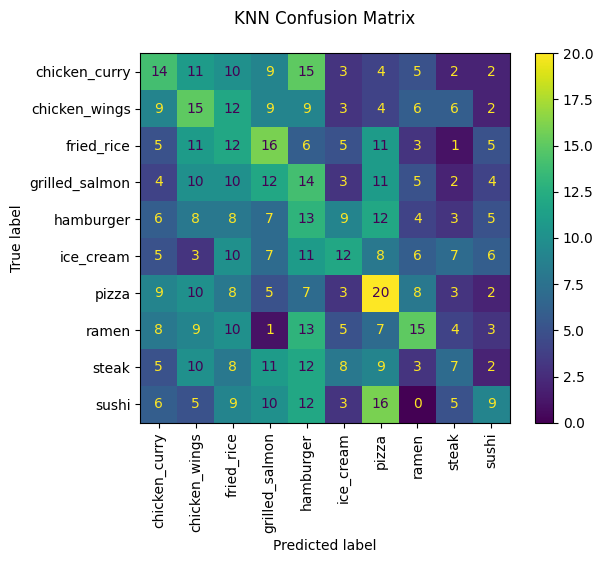

In [48]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred_knn, y_true=y_test, ax=ax, display_labels=class_names)
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)
ax.set_title("KNN Confusion Matrix\n");

### 7.4 Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [50]:
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.29      0.27      0.28        75
           1       0.24      0.27      0.25        75
           2       0.16      0.12      0.14        75
           3       0.24      0.21      0.23        75
           4       0.20      0.21      0.20        75
           5       0.26      0.29      0.27        75
           6       0.21      0.25      0.23        75
           7       0.26      0.28      0.27        75
           8       0.26      0.24      0.25        75
           9       0.24      0.21      0.23        75

    accuracy                           0.24       750
   macro avg       0.24      0.24      0.23       750
weighted avg       0.24      0.24      0.23       750



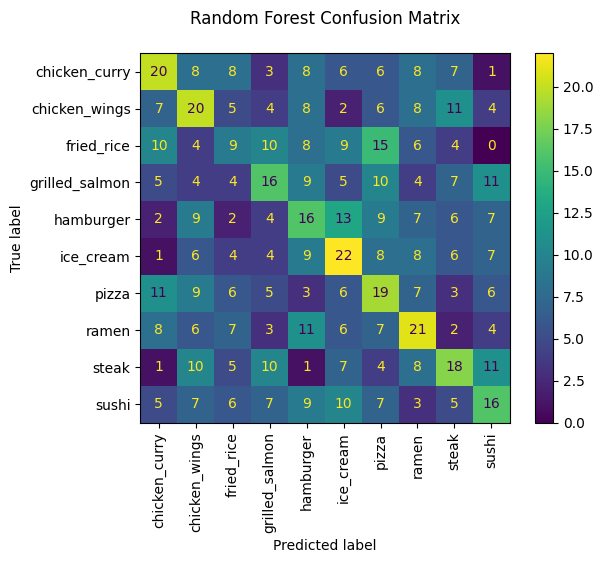

In [52]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred_rf , y_true=y_test, ax=ax, display_labels=class_names)
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)
ax.set_title("Random Forest Confusion Matrix\n");

### 7.5 Gaussian Naive Bayes

In [53]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_train, y_train)

GaussianNB()

In [54]:
y_pred_nb = nb.predict(X_test)

In [55]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.12      0.39      0.18        75
           1       0.00      0.00      0.00        75
           2       0.00      0.00      0.00        75
           3       0.24      0.12      0.16        75
           4       0.00      0.00      0.00        75
           5       0.00      0.00      0.00        75
           6       0.16      0.23      0.19        75
           7       0.12      0.33      0.18        75
           8       0.12      0.09      0.11        75
           9       0.18      0.20      0.19        75

    accuracy                           0.14       750
   macro avg       0.09      0.14      0.10       750
weighted avg       0.09      0.14      0.10       750



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'Gaussian Naive Bayes Confusion Matrix\n')

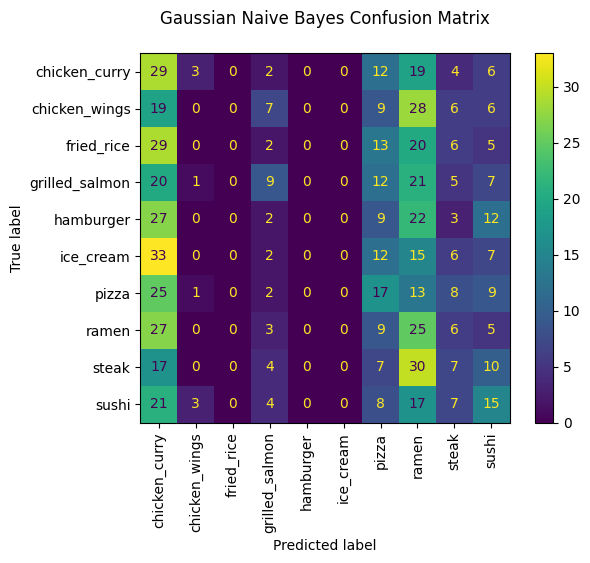

In [57]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred_nb , y_true=y_test, ax=ax, display_labels=class_names)
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)
ax.set_title("Gaussian Naive Bayes Confusion Matrix\n")

/tmp/ipython-input-3660873388.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


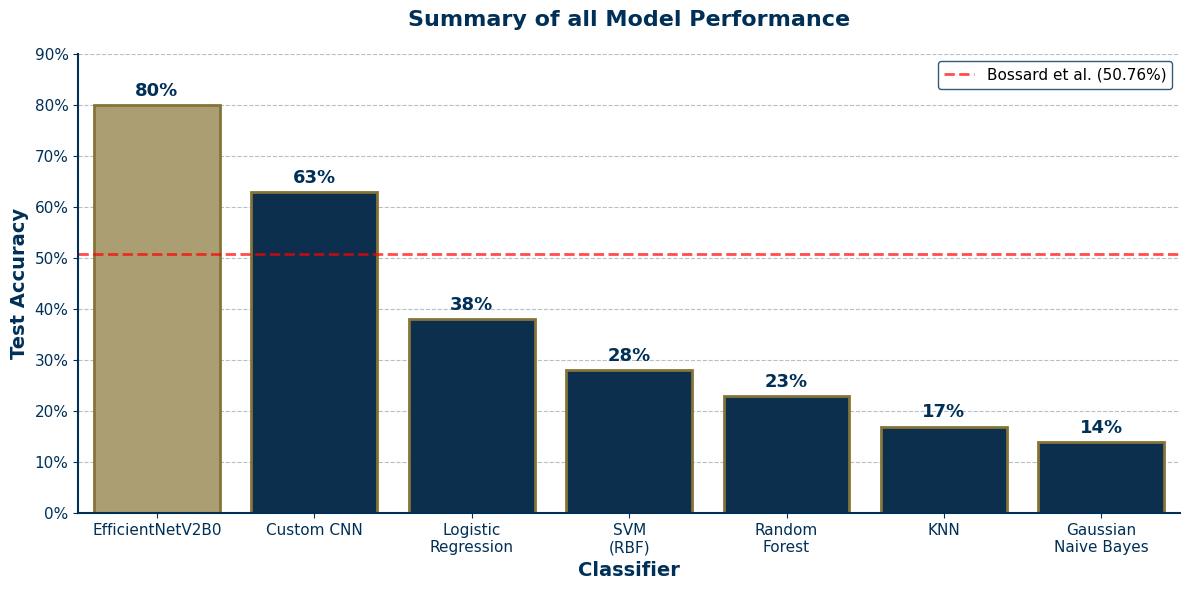

In [26]:
# Georgia Tech Colors (from your brand guide)
GT_GOLD = (179/255, 163/255, 105/255)
GT_NAVY = (0/255, 48/255, 87/255)
GT_GOLD_DARK = (133/255, 116/255, 55/255)

# Classifier results
classifiers = ["EfficientNetV2B0","Custom CNN",'Logistic\nRegression', 'SVM\n(RBF)', 'Random\nForest', 'KNN', 'Gaussian\nNaive Bayes']
accuracies = [0.80, 0.63,0.38, 0.28, 0.23, 0.17, 0.14]

# Create DataFrame
df = pd.DataFrame({
    'Classifier': classifiers,
    'Accuracy': accuracies
})

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Color palette: Gold for best, Navy for others
colors = [GT_GOLD if i == 0 else GT_NAVY for i in range(len(classifiers))]

# Create bar chart
bars = sns.barplot(
    data=df, 
    x='Classifier', 
    y='Accuracy', 
    palette=colors,
    edgecolor=GT_GOLD_DARK,
    linewidth=2,
    ax=ax
)

# Add value labels on top of bars
for i, (bar, acc) in enumerate(zip(bars.patches, accuracies)):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f'{acc:.0%}',
        ha='center',
        va='bottom',
        fontsize=13,
        fontweight='bold',
        color=GT_NAVY
    )

# Customize plot
ax.set_ylabel('Test Accuracy', fontsize=14, fontweight='bold', color=GT_NAVY)
ax.set_xlabel('Classifier', fontsize=14, fontweight='bold', color=GT_NAVY)
ax.set_title('Summary of all Model Performance', 
             fontsize=16, fontweight='bold', color=GT_NAVY, pad=20)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.set_ylim(0, 0.90)

# Grid and styling
ax.grid(axis='y', alpha=0.3, linestyle='--', color=GT_NAVY)
ax.set_axisbelow(True)

# Remove top/right spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color(GT_NAVY)
    ax.spines[spine].set_linewidth(1.5)

ax.tick_params(colors=GT_NAVY, labelsize=11)

# Add Bossard baseline reference line
ax.axhline(y=0.5076, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label='Bossard et al. (50.76%)')
ax.legend(loc='upper right', fontsize=11, frameon=True, 
          facecolor='white', edgecolor=GT_NAVY)

plt.tight_layout()

plt.show()


/tmp/ipython-input-519742060.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


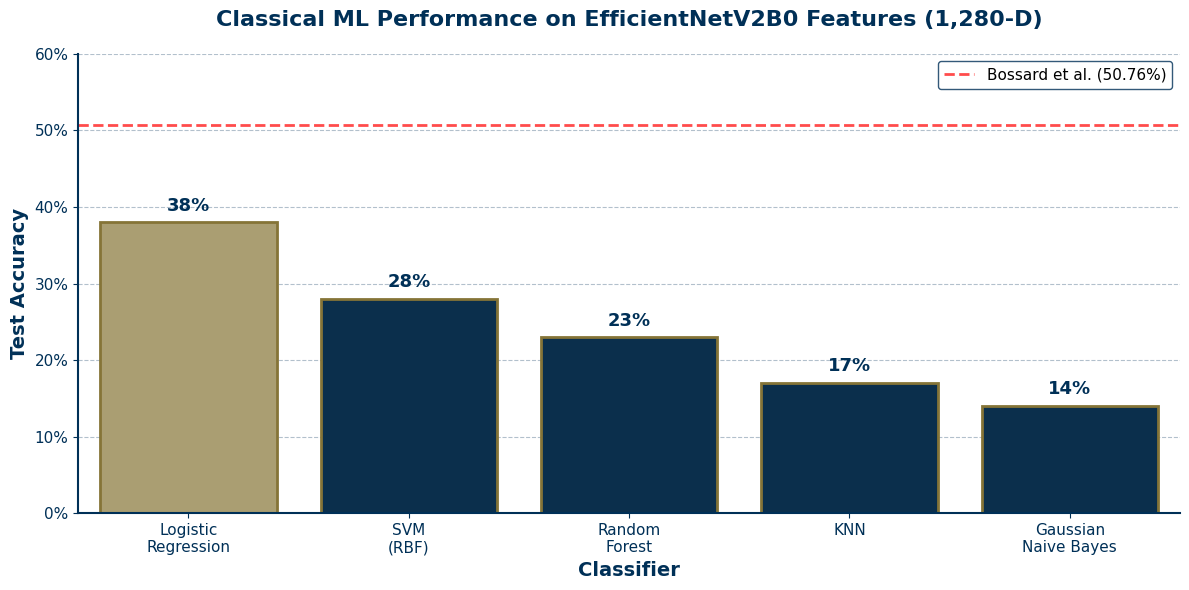

In [25]:
# Georgia Tech Colors (from your brand guide)
GT_GOLD = (179/255, 163/255, 105/255)
GT_NAVY = (0/255, 48/255, 87/255)
GT_GOLD_DARK = (133/255, 116/255, 55/255)

# Classifier results
classifiers = ['Logistic\nRegression', 'SVM\n(RBF)', 'Random\nForest', 'KNN', 'Gaussian\nNaive Bayes']
accuracies = [0.38, 0.28, 0.23, 0.17, 0.14]

# Create DataFrame
df = pd.DataFrame({
    'Classifier': classifiers,
    'Accuracy': accuracies
})

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Color palette: Gold for best, Navy for others
colors = [GT_GOLD if i == 0 else GT_NAVY for i in range(len(classifiers))]

# Create bar chart
bars = sns.barplot(
    data=df, 
    x='Classifier', 
    y='Accuracy', 
    palette=colors,
    edgecolor=GT_GOLD_DARK,
    linewidth=2,
    ax=ax
)

# Add value labels on top of bars
for i, (bar, acc) in enumerate(zip(bars.patches, accuracies)):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f'{acc:.0%}',
        ha='center',
        va='bottom',
        fontsize=13,
        fontweight='bold',
        color=GT_NAVY
    )

# Customize plot
ax.set_ylabel('Test Accuracy', fontsize=14, fontweight='bold', color=GT_NAVY)
ax.set_xlabel('Classifier', fontsize=14, fontweight='bold', color=GT_NAVY)
ax.set_title('Classical ML Performance on EfficientNetV2B0 Features (1,280-D)', 
             fontsize=16, fontweight='bold', color=GT_NAVY, pad=20)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.set_ylim(0, 0.60)

# Grid and styling
ax.grid(axis='y', alpha=0.3, linestyle='--', color=GT_NAVY)
ax.set_axisbelow(True)

# Remove top/right spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color(GT_NAVY)
    ax.spines[spine].set_linewidth(1.5)

ax.tick_params(colors=GT_NAVY, labelsize=11)

# Add Bossard baseline reference line
ax.axhline(y=0.5076, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label='Bossard et al. (50.76%)')
ax.legend(loc='upper right', fontsize=11, frameon=True, 
          facecolor='white', edgecolor=GT_NAVY)

plt.tight_layout()
# plt.savefig('classifier_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
